## Chapter 5: Pretraining on Unlabeled Data

### 5.1 Evaluating Generate Text models

In [1]:
import torch
from core import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # we use a shorer context length to make it easier to train on a laptop
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (tf_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm_1): LayerNorm()
      (mha): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout_1): Dropout(p=0.1, inplace=False)
      (layer_norm_2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout_2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (lay

In [2]:
import tiktoken
from core import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # unsqueeze to add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # squeeze to remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model,
    text_to_token_ids(start_context, tokenizer),
    10,
    GPT_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Let's try calculating the loss for some small text snippets

In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

In [4]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

In [5]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print("Probas shape:", probas.shape)

Probas shape: torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Ok, so clearly it's wrong, but how do we get to loss? 

First let's see the computed "target probabilities", i.e. "What probability the model assigns to the correct word"?

Then we can calculate the loss as the negative log of the target probability of the correct word.

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, range(3), targets[text_idx]]
print("Text 1 target probabilities:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, range(3), targets[text_idx]]
print("Text 2 target probabilites:", target_probas_2)

Text 1 target probabilities: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2 target probabilites: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


The baseline probabilities here are about equal to `1 / (vocab size)`, which is 1/50257. 
The model is not trained yet.

In [9]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [10]:
avg_prob = torch.mean(log_probas)
neg_avg_prob = -avg_prob
print("Loss:", neg_avg_prob)

Loss: tensor(10.7940)


This process to get loss can be handled more simply via the built in "Cross Entropy Loss" function in PyTorch.

In [11]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [12]:
# combine over the batch dimension
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened logits shape:", logits_flat.shape)
print("Flattened targets shape:", targets_flat.shape)

Flattened logits shape: torch.Size([6, 50257])
Flattened targets shape: torch.Size([6])


In [13]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross-entropy loss:", loss)

Cross-entropy loss: tensor(10.7940)


In [14]:
print("Perplexity:", torch.exp(loss))

Perplexity: tensor(48725.8203)


Next up: computing training and validation losses

In [15]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [16]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Total characters:", total_characters)
print("Total tokens:", total_tokens)

Total characters: 20479
Total tokens: 5145


In [17]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
print("Train data:\n", train_data[0:50], "...", train_data[-50:])
print("Val data:\n", val_data)

Train data:
 I HAD always thought Jack Gisburn rather a cheap g ...  and watched me, the thing they called my 'techniq
Val data:
 ue' collapsed like a house of cards. He didn't sneer, you understand, poor Stroud--he just lay there quietly watching, and on his lips, through the gray beard, I seemed to hear the question: 'Are you sure you know where you're coming out?'

"If I could have painted that face, with that question on it, I should have done a great thing. The next greatest thing was to see that I couldn't--and that grace was given me. But, oh, at that minute, Rickham, was there anything on earth I wouldn't have given to have Stroud alive before me, and to hear him say: 'It's not too late--I'll show you how'?

"It _was_ too late--it would have been, even if he'd been alive. I packed up my traps, and went down and told Mrs. Stroud. Of course I didn't tell her _that_--it would have been Greek to her. I simply said I couldn't paint him, that I was too moved. She rather liked the ide

In [18]:
from core import create_dataloader_v1

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle=True,
    num_workers = 0
)

val_loader= create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle= False,
    num_workers = 0
)

torch.manual_seed(0)
print("Train loader:")
for x,y in train_loader:

    print(x.shape, y.shape)

print("Validation loader:")
for x,y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [19]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten(0, 1))
    return loss

In [20]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # this allows us to calculate the loss on a subset of the data
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
# NOTE: seeing odd results when using CPU.
#   ex. manual_seed not producing same result
#   ex. can't reload a saved model to continue pre-training
#   ... falling back to just "cpu" for now

# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Train loss:", train_loss)
print("Val loss:", val_loss)

Train loss: 10.987583054436577
Val loss: 10.98110580444336


### 5.2 Training the LLM

In [22]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # calc loss gradients
            optimizer.step() # update model weights, given loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Epoch {epoch+1} (Step {global_step:06d}):"
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # disable dropout
    with torch.no_grad(): # disable gradient tracking (reduces computational overhead)
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train() # re-enable dropout
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval() # disable dropout
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        max_new_tokens = 50
        token_ids = generate_text_simple(model, encoded, max_new_tokens, context_size)

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train() # re-enable dropout

Ok! Let's connect it all. We'll use AdamW (weight decay) as the optimizer.

In [23]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Epoch 1 (Step 000000):Train loss 10.858, Val loss 10.893
Epoch 1 (Step 000005):Train loss 10.521, Val loss 10.596
Every effort moves you Trump Trump Trump Contracts Trump Contracts Trump Contracts Trump Contracts Immigration Contracts Contracts Contractsetsy Contracts Contracts Contracts investigative Trump Contracts Contractsiques Contracts Patricia Trump spend Contracts Contracts Patricia Trump Contracts Patricia Trump Trump Trump Contracts Patricia Trump Contracts Trump Contracts Contracts Trump Contracts Patricia Trump Contracts Contracts Patricia
Epoch 2 (Step 000010):Train loss 10.044, Val loss 10.135
Epoch 2 (Step 000015):Train loss 8.923, Val loss 9.112


KeyboardInterrupt: 

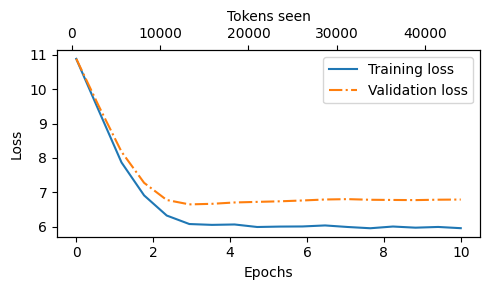

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, label="Validation loss", linestyle="-.")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    # NOTE: I don't see any effect of the below command...
    # ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2= ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot, to align ticks
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_seen = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_seen, tokens_seen, train_losses, val_losses)

### 5.3 Decoding strategies to control randomness

In [ ]:
model.to("cpu") # cpu is sufficient for inference
model.eval() # disable random components like dropout

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (tf_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm_1): LayerNorm()
      (mha): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout_1): Dropout(p=0.1, inplace=False)
      (layer_norm_2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout_2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (lay

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model,
    text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,


The above output is currently deterministic due to how we always select the most probable next word. 

Let's try adjusting our strategy for choosing the next word:

1. choose from the probability distribution
2. use temperature scaling (scale the logits) to adjust randomness
  - low temp = less randomness (more likely to choose the most probable word)
  - high temp = more randomness (smooths the distribution)
3. top-k sampling: only consider the top k most probable words

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
probas = torch.softmax(next_token_logits, dim=-1)
next_token_id = torch.argmax(probas).item()
print("next word:", inverse_vocab[next_token_id])

next word: forward


In [ ]:
# to do sampling, we replace argmax with multi-nomial sampling
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print("next word:", inverse_vocab[next_token_id])

next word: forward


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    # bincount gives the frequency of each value
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{inverse_vocab[i]:<10}: {freq.item()}")

print_sampled_tokens(probas)

closer    : 73
every     : 0
effort    : 0
forward   : 582
inches    : 2
moves     : 0
pizza     : 0
toward    : 343


Text(0, 0.5, 'Probability')

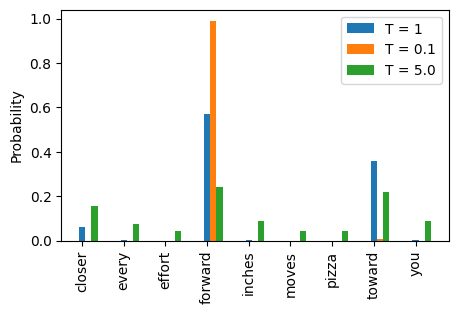

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

temperatures = [1, 0.1, 5.]
scaled_probas = [softmax_with_temperature(next_token_logits, t) for t in temperatures]

# Graph the scaled probas
fig, ax = plt.subplots(figsize=(5,3))
x = torch.arange(len(vocab))
bar_width = 0.15
for i, t in enumerate(temperatures):
    ax.bar(x + i*bar_width, scaled_probas[i], bar_width, label=f"T = {t}")
ax.set_xticks(range(len(vocab)))
ax.set_xticklabels(inverse_vocab.values(), rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Probability")


_Exercise 5.1:Use the print_sampled_tokens function to print the sampling frequencies of the softmax probabilities scaled with the temperatures shown in figure 5.14._

_How often is the word pizza sampled in each case? Can you think of a faster and more accurate way to determine how often the word pizza is sampled?_

In [ ]:
for i, t in enumerate(temperatures):
    print(f"Temperature = {t} ...")
    print_sampled_tokens(scaled_probas[i])

# How often is the word pizza sampled in each case?
# t=1     pizza =0
# t=0.1   pizza = 0
# t=5     pizza = 32

# faster and more accurate approach?
# -> we can calculate the expected count of the word pizza based
#   on the probability distribution
for i, t in enumerate(temperatures):
    pizza_idx = vocab["pizza"]
    p = scaled_probas[i][pizza_idx]
    expected = p * 1000
    print(f"Temperature = {t:.1f}, p = {p:.3f}, expected pizza count: {expected:.0f}")


Temperature = 1 ...
closer    : 73
every     : 0
effort    : 0
forward   : 582
inches    : 2
moves     : 0
pizza     : 0
toward    : 343
Temperature = 0.1 ...
closer    : 0
every     : 0
effort    : 0
forward   : 985
inches    : 0
moves     : 0
pizza     : 0
toward    : 15
Temperature = 5.0 ...
closer    : 165
every     : 75
effort    : 42
forward   : 239
inches    : 71
moves     : 46
pizza     : 32
toward    : 227
you       : 103
Temperature = 1.0, p = 0.000, expected pizza count: 0
Temperature = 0.1, p = 0.000, expected pizza count: 0
Temperature = 5.0, p = 0.043, expected pizza count: 43


In order to constrain the randomness, let's try **top-K sampling**

In [ ]:
def top_k_mask(logits, k=3, is_batch=False):
    top_values, _ = torch.topk(logits, k)
    min_value = top_values[:, -1] if is_batch else top_values[-1]
    new_logits = torch.where(
        condition=logits < min_value,
        input= torch.tensor(-1 * torch.inf).to(logits.device),
        other=logits,
    )
    return new_logits

In [ ]:
print(next_token_logits)
print(top_k_mask(next_token_logits, k=3))
print(top_k_mask(next_token_logits, k=2))

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([  -inf,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [ ]:
top_k_probas = torch.softmax(top_k_mask(next_token_logits, k=3), dim=-1)
print(top_k_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Here's a modified text generation with more diverse outputs.

We incorporate the multinomial sampling, temperature scaling, and top-k sampling strategies.

We also add an early exit condition if we generate an "end-of-sequence" token.

In [ ]:
# modified text generation with more diverse outputs
def generate(model, token_ids, max_new_tokens, context_size, temperature=0.0, top_k: int|None=None, eos_id=None):
    for i in range(max_new_tokens):
        # all samples in batch .. most-recent `<= context_size` tokens
        x = token_ids[:, -context_size:]
        with torch.no_grad():  # during inference, we don't need backprop
            logits = model(x)

        token = next_token_id_v2(logits, temperature=temperature, top_k=top_k)
        token_ids = torch.cat((token_ids, token), dim=1)
        if token == eos_id:
            # exit early if we encounter the end-of-sequence token
            break

    return token_ids


def next_token_id_v2(batch_logits, temperature=0.1, top_k: int|None=3):
    """Given batched model output, return next token's id"""
    # for each sample in batch, select logits for last token
    logits = batch_logits[:, -1, :]

    if top_k is not None:
        # mask logits to only keep top-k values
        logits = top_k_mask(logits, k=top_k, is_batch=True)

    if temperature > 0.0:
        # use temperature to scale logits
        logits = logits / temperature

        # softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)

        # choose token id using multinoimal sampling
        token_id = torch.multinomial(probas, num_samples=1)
    else:
        token_id = torch.argmax(logits, dim=-1)

    return token_id


In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model,
    text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

tensor([[6109, 3626, 6100,  345]])
tensor([[1]])
tensor([[6109, 3626, 6100,  345,    1]])
tensor([[1]])
tensor([[6109, 3626, 6100,  345,    1,    1]])
tensor([[13]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13]])
tensor([[314]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314]])
tensor([[340]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340]])
tensor([[257]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257]])
tensor([[11]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11]])
tensor([[13]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11,   13]])
tensor([[465]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11,   13,
          465]])
tensor([[502]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11,   13,
          465,  502]])
tensor([[366]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11,   13,
          465,  5

_Exercise 5.2_

_Play around with different temperatures and top-k settings. Based on your observations, can you think of applications where lower temperature and top-k settings are desired? Likewise, can you think of applications where higher temperature and top-k settings are preferred?_

Lower temperature and top-k would be desireable if you need a more deterministic output
For example, suppose you want to write in a very strict format. This could also include very specific formatting like code generation.

Higher temperature and top-k would be desirable if you want more randomness.
For example, creative writing, or brainstorming session._


In [ ]:
for t in [0.0, 0.1, 0.5, 1.0, 1.5, 2.0]:
    for top_k in [1, 3, 5, 10, None]:
        print(f"Temperature = {t}, top_k = {top_k}")
        torch.manual_seed(123)
        token_ids = generate(
    model,
    text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)
        text = token_ids_to_text(token_ids, tokenizer)
        print(text)
        print("")


Temperature = 0.0, top_k = 1
tensor([[6109, 3626, 6100,  345]])
tensor([[1]])
tensor([[6109, 3626, 6100,  345,    1]])
tensor([[1]])
tensor([[6109, 3626, 6100,  345,    1,    1]])
tensor([[13]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13]])
tensor([[314]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314]])
tensor([[340]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340]])
tensor([[257]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257]])
tensor([[11]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11]])
tensor([[13]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11,   13]])
tensor([[465]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11,   13,
          465]])
tensor([[502]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257,   11,   13,
          465,  502]])
tensor([[366]])
tensor([[6109, 3626, 6100,  345,    1,    1,   13,  314,  340,  257, 

_Exercise 5.3_

_What are the different combinations of settings for the generate function to force deterministic behavior, that is, disabling the random sampling such that it always produces the same outputs similar to the generate_simple function?_

- temperature = 0 forces determinism (falls back to argmax, so always chooses the most probable word)
  - book says "Setting to top_k=None and applying no temperature scaling".. but I think temp=0 alone is enough
- top_k sampling with k = 1 also forces determinism (always chooses the most probable word), regardless of temperature


### 5.4 Saving and Loading model weights


In [ ]:
# The basic approach is pretty straightforward!
model_state = model.state_dict()
torch.save(model_state, "model.pth")

# If we want to continue pretraining later, we can save the optimizer state
optimizer_state = optimizer.state_dict()
torch.save(optimizer_state, "optimizer.pth")

# We can also save multiple at once!
torch.save(
    {
    "model_state_dict": model_state,
    "optimizer_state_dict": optimizer_state,
    },
    "model_and_optimizer.pth"
)

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
# we load the weights AND we also map them to the appropriate device (cuda, cpu, etc)
model.load_state_dict(torch.load("model.pth", map_location=device))
# training off, eval (inference) on!
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (tf_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm_1): LayerNorm()
      (mha): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout_1): Dropout(p=0.1, inplace=False)
      (layer_norm_2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout_2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (lay

Now let's restore the model and optimizer state...

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train(); # we can resume pre-training.. the optimizer is also is the right state

In [ ]:
""""
Exercise 5.4
After saving the weights, load the model and optimizer in a new Python session or Jupyter notebook file
and continue pretraining it for one more epoch using the train_model_simple function.

- load the model and optimizer
- num_epochs=1
- if we were in another session, we'd also need to bring along the train_loader and val_loader
"""

def load_model_for_training(path="model_and_optimizer.pth"):
    checkpoint = torch.load(path, map_location=device)
    model = GPTModel(GPT_CONFIG_124M)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    model.train()
    return model, optimizer

model2, optimizer2= load_model_for_training("model_and_optimizer.pth")
num_epochs = 1 # 1 more
train_model_simple(
    model2, train_loader, val_loader, optimizer2, device,
    num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

RuntimeError: Placeholder storage has not been allocated on MPS device!

### 5.5 Loading pretrained weights from OpenAI

In [ ]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x160e9f8b0>)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 30.4kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.48MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 30.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [05:15<00:00, 1.58MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.20MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.50MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.53MiB/s]


In [ ]:
print("Settings:", settings)
print("Param keys:", params.keys())
print("Param wte: ", params["wte"])
print("Token embedding weight tensor dims: ", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Param keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Param wte:  [[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dims:  (50257, 768)


In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_heads": 12, "n_layers": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_heads": 16, "n_layers": 24},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_heads": 20, "n_layers": 36},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_heads": 25, "n_layers": 48},
}

In [ ]:
def create_gpt2_model(model_name = "gpt2-small (124M)"):
    model_config = GPT_CONFIG_124M.copy()
    model_config.update(model_configs[model_name])
    # we had used 256 for faster local training
    model_config.update({"context_length": 1024})
    # GPT2 had bias vectors in qkv
    model_config.update({"qkv_bias": True})

    model = GPTModel(model_config)
    return model


In [ ]:
# import numpy as np

# # Now we need to load weights.

# # First let's make a method to assign weights
# # It can sanity check we don't make silly mistakes
# # NOTE: This is variant of the book code that overwrites in place,
# # to be more concise in the load_weights_into_gpt fn below
# def assign(left, right: np.ndarray):
#     if left.shape != right.shape:
#         raise ValueError(f"Shape mistmatch {left.shape} != {right.shape}")
#     left.data = torch.tensor(right)

# def load_weights_into_gpt(gpt: GPTModel, params):
#     # position and token embeddings
#     assign(gpt.pos_emb.weight, params["wpe"])
#     assign(gpt.token_emb.weight, params["wte"])

#     # tranformer layers
#     for b in range(len(params["blocks"])):
#         ## multi-head attention
#         w_q, w_k, w_v = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])['w'], 3, axis=-1)
#         assign(gpt.tf_blocks[b].mha.W_query.weight, w_q.T)
#         assign(gpt.tf_blocks[b].mha.W_key.weight, w_k.T)
#         assign(gpt.tf_blocks[b].mha.W_value.weight, w_v.T)

#         b_q, b_k, b_v = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])['b'], 3, axis=-1
#         )
#         assign(gpt.tf_blocks[b].mha.W_query.bias, b_q)
#         assign(gpt.tf_blocks[b].mha.W_key.bias, b_k)
#         assign(gpt.tf_blocks[b].mha.W_value.bias, b_v)

#         assign(gpt.tf_blocks[b].mha.out_proj.weight,  params["blocks"][b]["attn"]["c_proj"]["w"].T)
#         assign(gpt.tf_blocks[b].mha.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])


#         ## feed forward
#         assign(gpt.tf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
#         assign(gpt.tf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])

#         assign(gpt.tf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
#         assign(gpt.tf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

#         # layer norms
#         assign(gpt.tf_blocks[b].layer_norm_1.scale, params["blocks"][b]["ln_1"]["g"])
#         assign(gpt.tf_blocks[b].layer_norm_1.shift, params["blocks"][b]["ln_1"]["b"])

#         assign(gpt.tf_blocks[b].layer_norm_2.scale, params["blocks"][b]["ln_2"]["g"])
#         assign(gpt.tf_blocks[b].layer_norm_2.shift, params["blocks"][b]["ln_2"]["b"])

#     assign(gpt.final_layer_norm.scale, params["g"])
#     assign(gpt.final_layer_norm.shift, params["b"])
#     assign(gpt.linear_output.weight, params["wte"]) # weight tied to the input token embedding


In [ ]:
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):           #1
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):     #2
        q_w, k_w, v_w = np.split(                            #3
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.tf_blocks[b].mha.W_query.weight = assign(
            gpt.tf_blocks[b].mha.W_query.weight, q_w.T)
        gpt.tf_blocks[b].mha.W_key.weight = assign(
            gpt.tf_blocks[b].mha.W_key.weight, k_w.T)
        gpt.tf_blocks[b].mha.W_value.weight = assign(
            gpt.tf_blocks[b].mha.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.tf_blocks[b].mha.W_query.bias = assign(
            gpt.tf_blocks[b].mha.W_query.bias, q_b)
        gpt.tf_blocks[b].mha.W_key.bias = assign(
            gpt.tf_blocks[b].mha.W_key.bias, k_b)
        gpt.tf_blocks[b].mha.W_value.bias = assign(
            gpt.tf_blocks[b].mha.W_value.bias, v_b)

        gpt.tf_blocks[b].mha.out_proj.weight = assign(
            gpt.tf_blocks[b].mha.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.tf_blocks[b].mha.out_proj.bias = assign(
            gpt.tf_blocks[b].mha.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.tf_blocks[b].ff.layers[0].weight = assign(
            gpt.tf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.tf_blocks[b].ff.layers[0].bias = assign(
            gpt.tf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.tf_blocks[b].ff.layers[2].weight = assign(
            gpt.tf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.tf_blocks[b].ff.layers[2].bias = assign(
            gpt.tf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.tf_blocks[b].layer_norm_1.scale = assign(
            gpt.tf_blocks[b].layer_norm_1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.tf_blocks[b].layer_norm_1.shift = assign(
            gpt.tf_blocks[b].layer_norm_1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.tf_blocks[b].layer_norm_2.scale = assign(
            gpt.tf_blocks[b].layer_norm_2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.tf_blocks[b].layer_norm_2.shift = assign(
            gpt.tf_blocks[b].layer_norm_2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_layer_norm.scale = assign(gpt.final_layer_norm.scale, params["g"])
    gpt.final_layer_norm.shift = assign(gpt.final_layer_norm.shift, params["b"])
    gpt.linear_output.weight = assign(gpt.linear_output.weight, params["wte"])    #4

In [ ]:
gpt = create_gpt2_model("gpt2-small (124M)")
gpt.eval(); # TIL can use ; to suppress output in Jupyter

load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)
max_new_tokens=25
context_size=1024
token_ids = generate(
    gpt,
    text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens,
    context_size,
    top_k=50,
    temperature=1.5,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you not" an I it a ' is at' " or for " by at was- on, on A ( the one
